# Deep Learning Introduction in NumPy

In [59]:
%matplotlib inline  
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Data

In [60]:
X, y = make_moons(n_samples = 500, noise = 0.2, random_state = 101)

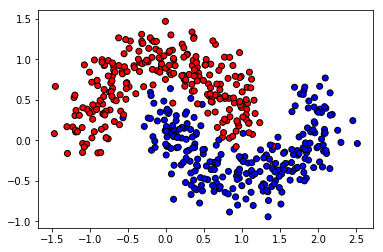

In [61]:
# visualisation
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y, edgecolors='k', cmap = cm_bright)

## Logistic Regression

In our example, the output of the logistic regression is a value between 0 and 1 that tells the probability of a point being blue or red. The input of the model are the coordinates of the point.

$$f_{\theta}(x) = \frac{1}{1+\exp(-(\theta_0 + \theta_1 x_1 + \ldots + \theta_n x_n))}$$

In [62]:
clf = LogisticRegressionCV()
clf.fit(X,y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

We plot the result. We see how the model is actually finding a hyperplane defined by $\theta_0 + \theta_1 x_1 + \ldots + \theta_n x_n = 0$ that tries to separate the data

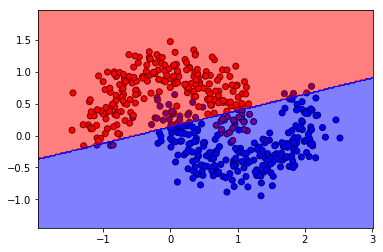

In [63]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y, edgecolors='k', cmap = cm_bright)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.02 # step in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_binary = Z>=0
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)

## Neural Networks

### Ingredients

- Definition of the model to do a forward pass: $y = \sigma(W^{[L-1]}(\sigma(W^{[L-2]}(... \sigma(W^{[1]}x + b^{[1]})...)+b^{[L-2]}))+b^{[L-1]})$ where 
    - $\sigma$ is the activation function
    - $Wx + b$ is a linear function that goes from $\mathbb{R}^n$ to $\mathbb{R}^m$.
    - In our example, the output of the model is a value between 0 and 1 that tells the probability of a point being blue or red. The input of the model are the coordinates of the point. 
- Definition of a cost function that tells how good is the model in terms of its parameters: $$J(\theta), \text{where } \theta:=\{W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}\}$$
- Optimisation of the cost function using gradient descent.
    - We need to apply the chain rule (backpropagation) in order to obtain $\partial_{\theta}J$ for each optimisation step.
   

#### Activation function and model definition

In [64]:
# activation function
def sigmoid(z):
    output = 1/(1+np.exp(-z))
    return output

In [65]:
# forward_model.
# function that takes the input x, and outputs the output of the model, as well as the intermediate layers
# I am defining a neural network with one hidden layer.
def forward_model(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # forward pass
    # hidden layer
    z2 = np.matmul(x,W1) + b1
    a2 = sigmoid(z2)
    
    # output layer
    z3 = np.matmul(a2,W2) + b2
    a3 = sigmoid(z3)
    
    return z2, a2, z3, a3

#### Loss function
Let $\mathcal{D} = \{(x^1, y^1), (x^2, y^2), \ldots, (x^N, y^N)\}$ be our training set, where $x^i\in \mathbb{R}^n$
We define the loss function as $$J(\theta) = -\sum_{i=1}^{N} y^i \log(f_{\theta}(x^i)) + (1-y^i) \log(1-f_{\theta}(x^i))$$

In [66]:
def loss_fn(model, x, y):
    _,_,_,y_pred = forward_model(model, x)
    loss_batch = y * np.log(y_pred) + (1-y) * np.log(1-y_pred)
    return -np.sum(loss_batch)

#### Gradient descent step.
See for example (https://arxiv.org/pdf/1801.05894.pdf) for a general form of the gradient of the cost function for the parameters in each layer of the network.



In [67]:
def GD_step(model, x, y, lr = 0.001):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    z2, a2, z3, a3 = forward_model(model, x)
    
    delta3 = a3-y
    dW2 = np.matmul(a2.T,delta3)
    db2 = np.sum(delta3, axis=0, keepdims=True)
    
    delta2 = sigmoid(z2)*(1-sigmoid(z2)) * delta3.dot(W2.T)
    dW1 = np.matmul(x.T, delta2)
    db1 = np.sum(delta2, axis=0)
    
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    
    model['W1'], model['b1'], model['W2'], model['b2'] = W1, b1, W2, b2
    return model

#### We put everything together for the training:
- Initialise $W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}$.
- While Not convergence:
    - Calculate $J(\theta)$
    - Update $W^{[i]} := W^{[i]} - \alpha \cdot \partial_{W^{[i]}}J$
    - Update $b^{[i]} := b^{[i]} - \alpha \cdot \partial_{b^{[i]}}J$
    

In [68]:
def train(model, n_epochs, X, y):
    for epoch in range(n_epochs):
        model = GD_step(model, x=X, y=y)
        loss = loss_fn(model, x=X, y=y)
        if epoch%10 == 0:
            print("Epoch: {}/{}, loss: {}".format(epoch, n_epochs, loss))
    return model

In [69]:
n_hidden = 30
W1 = np.random.randn(2, n_hidden)
b1 = np.random.randn(1, n_hidden)
W2 = np.random.randn(n_hidden, 1)
b2 = np.random.randn(1,1)
model = {}
model['W1'], model['b1'], model['W2'], model['b2'] = W1, b1, W2, b2

model = train(model=model, n_epochs=10000, X=X, y=y.reshape(500,1))

Epoch: 0/10000, loss: 309.9094917133514
Epoch: 10/10000, loss: 201.87472399255302
Epoch: 20/10000, loss: 175.12684785944515
Epoch: 30/10000, loss: 162.32390236701536
Epoch: 40/10000, loss: 154.68697107628918
Epoch: 50/10000, loss: 149.66407125254938
Epoch: 60/10000, loss: 146.17301630083233
Epoch: 70/10000, loss: 143.65174128562148
Epoch: 80/10000, loss: 141.773808687599
Epoch: 90/10000, loss: 140.3366943108455
Epoch: 100/10000, loss: 139.20909698394885
Epoch: 110/10000, loss: 138.30303220141587
Epoch: 120/10000, loss: 137.5579405894071
Epoch: 130/10000, loss: 136.93118483674365
Epoch: 140/10000, loss: 136.39215362751193
Epoch: 150/10000, loss: 135.9184909779765
Epoch: 160/10000, loss: 135.4936210081391
Epoch: 170/10000, loss: 135.10508535173727
Epoch: 180/10000, loss: 134.74340347933702
Epoch: 190/10000, loss: 134.40127725711147
Epoch: 200/10000, loss: 134.07302680408588
Epoch: 210/10000, loss: 133.75418464968314
Epoch: 220/10000, loss: 133.44120003907415
Epoch: 230/10000, loss: 133.1

Epoch: 2070/10000, loss: 43.17800669352147
Epoch: 2080/10000, loss: 43.06154663175543
Epoch: 2090/10000, loss: 42.94670036930645
Epoch: 2100/10000, loss: 42.83343678909591
Epoch: 2110/10000, loss: 42.72172551522712
Epoch: 2120/10000, loss: 42.61153689277045
Epoch: 2130/10000, loss: 42.502841968137986
Epoch: 2140/10000, loss: 42.395612470030585
Epoch: 2150/10000, loss: 42.28982079094147
Epoch: 2160/10000, loss: 42.18543996919975
Epoch: 2170/10000, loss: 42.08244367153864
Epoch: 2180/10000, loss: 41.98080617617288
Epoch: 2190/10000, loss: 41.88050235637036
Epoch: 2200/10000, loss: 41.781507664503664
Epoch: 2210/10000, loss: 41.68379811656703
Epoch: 2220/10000, loss: 41.58735027714512
Epoch: 2230/10000, loss: 41.49214124482001
Epoch: 2240/10000, loss: 41.39814863800339
Epoch: 2250/10000, loss: 41.305350581181216
Epoch: 2260/10000, loss: 41.21372569155829
Epoch: 2270/10000, loss: 41.12325306609097
Epoch: 2280/10000, loss: 41.03391226889603
Epoch: 2290/10000, loss: 40.94568331902455
Epoch: 

Epoch: 4120/10000, loss: 33.557487690974675
Epoch: 4130/10000, loss: 33.53907433346357
Epoch: 4140/10000, loss: 33.52076674102267
Epoch: 4150/10000, loss: 33.502563904607996
Epoch: 4160/10000, loss: 33.48446482693069
Epoch: 4170/10000, loss: 33.466468522295116
Epoch: 4180/10000, loss: 33.44857401643958
Epoch: 4190/10000, loss: 33.430780346379734
Epoch: 4200/10000, loss: 33.413086560254776
Epoch: 4210/10000, loss: 33.39549171717599
Epoch: 4220/10000, loss: 33.37799488707809
Epoch: 4230/10000, loss: 33.360595150572806
Epoch: 4240/10000, loss: 33.34329159880508
Epoch: 4250/10000, loss: 33.32608333331161
Epoch: 4260/10000, loss: 33.30896946588161
Epoch: 4270/10000, loss: 33.2919491184201
Epoch: 4280/10000, loss: 33.27502142281322
Epoch: 4290/10000, loss: 33.25818552079586
Epoch: 4300/10000, loss: 33.24144056382151
Epoch: 4310/10000, loss: 33.22478571293402
Epoch: 4320/10000, loss: 33.208220138641686
Epoch: 4330/10000, loss: 33.19174302079327
Epoch: 4340/10000, loss: 33.175353548455874
Epoc

Epoch: 6160/10000, loss: 31.11611940787472
Epoch: 6170/10000, loss: 31.10801078538752
Epoch: 6180/10000, loss: 31.09992455864696
Epoch: 6190/10000, loss: 31.091860603960708
Epoch: 6200/10000, loss: 31.083818798755885
Epoch: 6210/10000, loss: 31.075799021567022
Epoch: 6220/10000, loss: 31.06780115202418
Epoch: 6230/10000, loss: 31.059825070841143
Epoch: 6240/10000, loss: 31.051870659803797
Epoch: 6250/10000, loss: 31.043937801758645
Epoch: 6260/10000, loss: 31.036026380601434
Epoch: 6270/10000, loss: 31.028136281265866
Epoch: 6280/10000, loss: 31.020267389712565
Epoch: 6290/10000, loss: 31.012419592917936
Epoch: 6300/10000, loss: 31.004592778863476
Epoch: 6310/10000, loss: 30.996786836524848
Epoch: 6320/10000, loss: 30.989001655861365
Epoch: 6330/10000, loss: 30.981237127805453
Epoch: 6340/10000, loss: 30.97349314425223
Epoch: 6350/10000, loss: 30.965769598049267
Epoch: 6360/10000, loss: 30.958066382986413
Epoch: 6370/10000, loss: 30.950383393785764
Epoch: 6380/10000, loss: 30.942720526

Epoch: 8210/10000, loss: 29.802277724604416
Epoch: 8220/10000, loss: 29.797176519553595
Epoch: 8230/10000, loss: 29.792085241566088
Epoch: 8240/10000, loss: 29.78700386222947
Epoch: 8250/10000, loss: 29.781932353273753
Epoch: 8260/10000, loss: 29.776870686570128
Epoch: 8270/10000, loss: 29.77181883412966
Epoch: 8280/10000, loss: 29.766776768102027
Epoch: 8290/10000, loss: 29.761744460774246
Epoch: 8300/10000, loss: 29.756721884569487
Epoch: 8310/10000, loss: 29.751709012045787
Epoch: 8320/10000, loss: 29.74670581589485
Epoch: 8330/10000, loss: 29.741712268940844
Epoch: 8340/10000, loss: 29.73672834413924
Epoch: 8350/10000, loss: 29.731754014575593
Epoch: 8360/10000, loss: 29.726789253464425
Epoch: 8370/10000, loss: 29.721834034148003
Epoch: 8380/10000, loss: 29.716888330095315
Epoch: 8390/10000, loss: 29.71195211490084
Epoch: 8400/10000, loss: 29.70702536228347
Epoch: 8410/10000, loss: 29.702108046085474
Epoch: 8420/10000, loss: 29.697200140271246
Epoch: 8430/10000, loss: 29.6923016189

#### Prediction

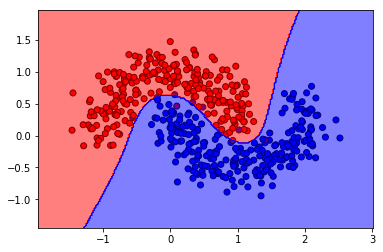

In [70]:
_,_,_,y_pred = forward_model(model, X)
y_pred = y_pred.ravel()

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y.ravel(), edgecolors='k', cmap = cm_bright)
_,_,_,Z = forward_model(model=model, x=np.c_[xx.ravel(), yy.ravel()])
Z_binary = Z>=0.5
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)